# Fine Tuning MobileBERT and TinyBERT for Fake News Detection

## Text Classification Architecture

https://www.kaggle.com/c/fake-news/data

- Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

- smam classification, sentiment classification, toxic comment, emotion classification etc.


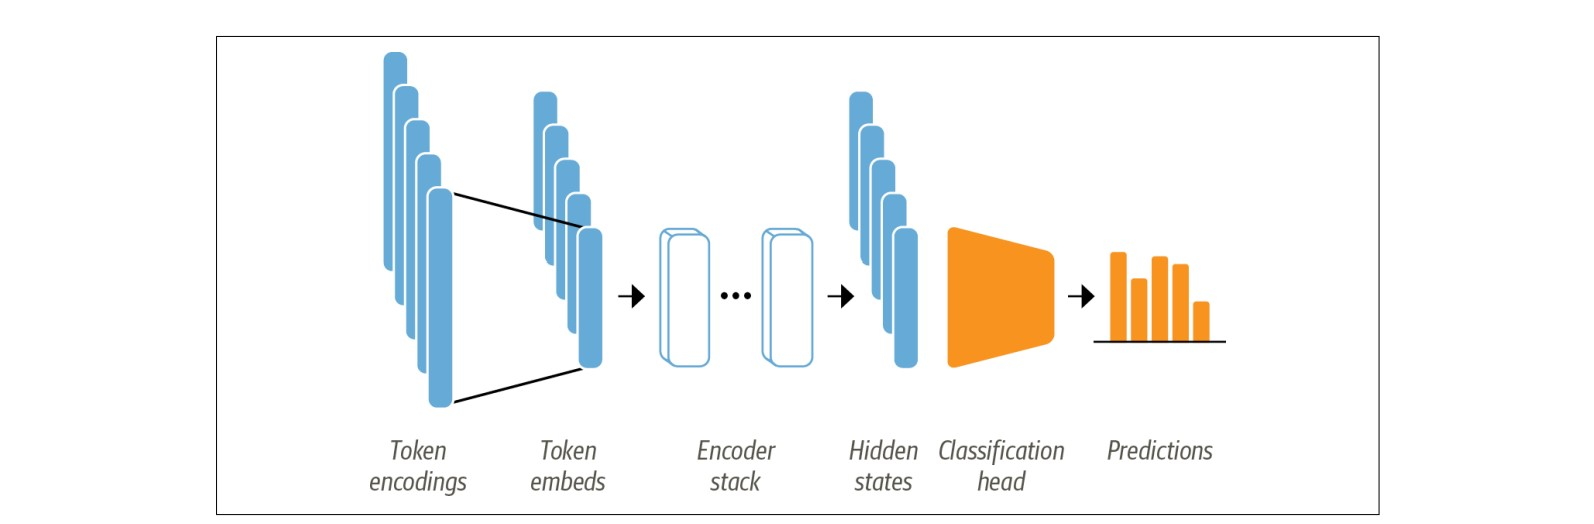

## Coding

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

!pip install -U openpyxl

# Don't do in production. Doing now to keep output clean for understanding
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 41.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [ ]:
import pandas as pd

df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")

In [ ]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [ ]:
df.shape

df['label'].value_counts()

,count
label,
0,10361
1,7920


## Dataset Analysis

In [ ]:
import matplotlib.pyplot as plt

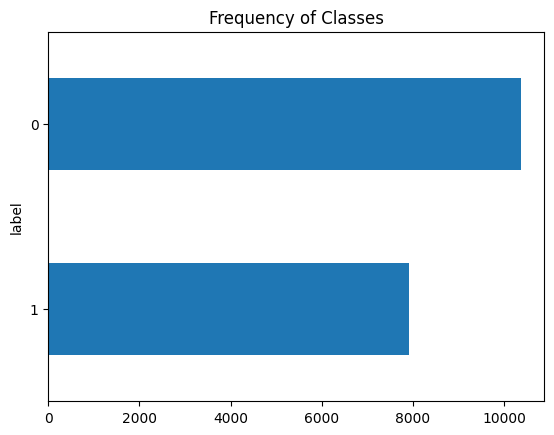

In [ ]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

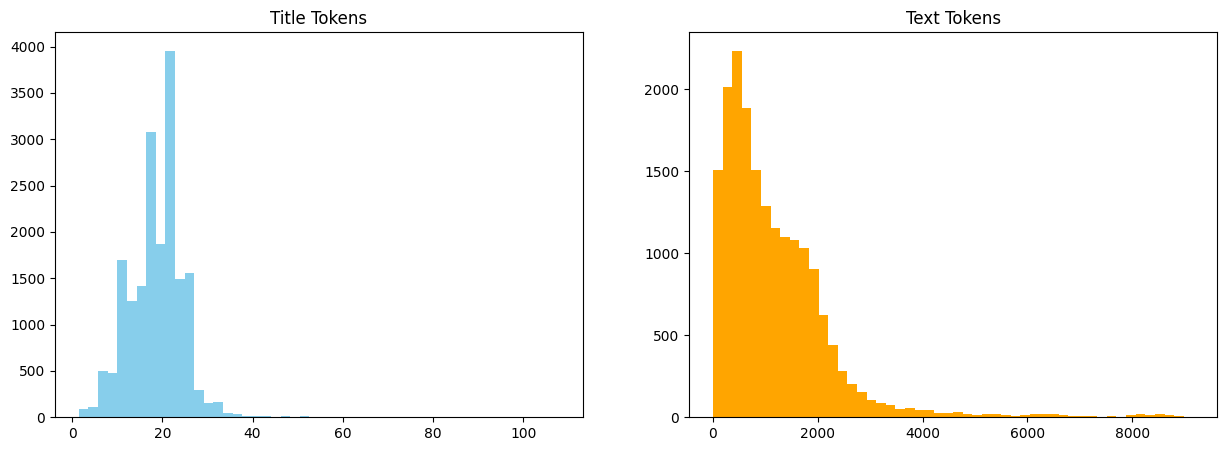

In [ ]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

## Data Loader and Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape



((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## Data Tokenization

In [ ]:
from transformers import AutoTokenizer

text = "Machine learning is awesome!! Thanks KGP Talkie."
'''
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
distilbert_tokens = distilbert_tokenizer.tokenize(text)
'''
model_ckpt = "google/mobilebert-uncased"
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)

model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tinybert_tokens = tinybert_tokenizer.tokenize(text)


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
mobilebert_tokenizer, tinybert_tokenizer

(MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 BertTokenizerFast(name_or_path='huawei-noah/TinyBERT_General_4L_312D', voca

In [ ]:
def tokenize(batch):
    temp = mobilebert_tokenizer(batch['title'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[101, 1996, 14163, 15952, 2925, 1997, 4517, 2373, 1999, 1996, 2142, 2163, 1011, 1996, 2047, 2259, 2335, 102, 0], [101, 2184, 2477, 2017, 2342, 2000, 2113, 2077, 3773, 1520, 3460, 4326, 1521, 1011, 1996, 2047, 2259, 2335, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
encoded_dataset = dataset.map(tokenize, batch_size=None, batched=True)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

## Model Building

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

#model_ckpt = "distilbert-base-uncased"
model_ckpt = "google/mobilebert-uncased"
model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"


num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)




pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Model Fine-Tuning

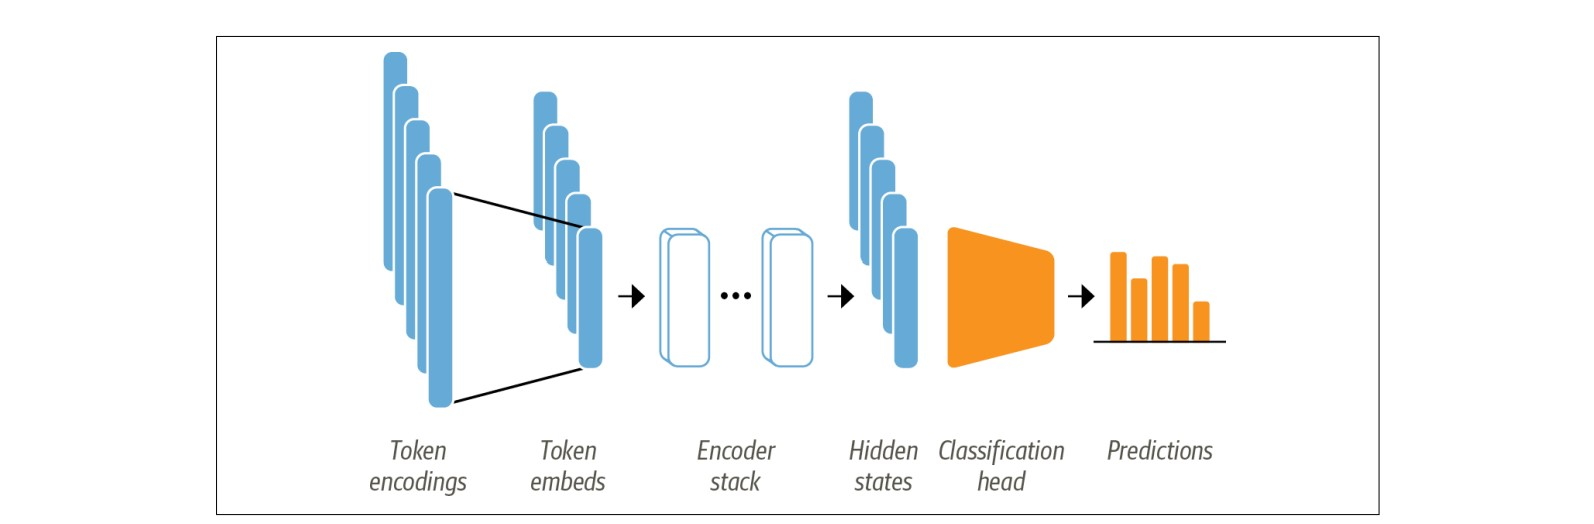

- `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs

- The first thing we need is a pretrained BERT-like model.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

#### Evaluator

https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [ ]:
# Build compute metrics function
!pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
from transformers import TrainingArguments

batch_size = 32
training_dir = "train_dir"

training_args = TrainingArguments(
                                  output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch'
)



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_evaluate,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=mobilebert_tokenizer
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,0.321800
1000,0.220100
1500,0.188800
2000,0.146200
2500,0.139400
3000,0.141200
3500,0.102900
4000,0.091800
4500,0.071700


TrainOutput(global_step=4800, training_loss=0.1533730411529541, metrics={'train_runtime': 290.563, 'train_samples_per_second': 132.116, 'train_steps_per_second': 16.52, 'total_flos': 103208510071296.0, 'train_loss': 0.1533730411529541, 'epoch': 3.0})

## Model Evaluation

In [ ]:
preds_output = trainer.predict(encoded_dataset['test'])


In [ ]:
preds_output.metrics

{'test_loss': 0.20571215450763702,
 'test_accuracy': 0.9567833698030634,
 'test_runtime': 3.7564,
 'test_samples_per_second': 973.279,
 'test_steps_per_second': 121.66}

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(label2id)))

              precision    recall  f1-score   support

        Real       0.95      0.97      0.96      2072
        Fake       0.96      0.94      0.95      1584

    accuracy                           0.96      3656
   macro avg       0.96      0.95      0.96      3656
weighted avg       0.96      0.96      0.96      3656



## Benchmarking

In [ ]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics


import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  bert-base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.267700
1000,0.196500
1500,0.163600
2000,0.118800
2500,0.091200
3000,0.098800
3500,0.059700
4000,0.043000
4500,0.044100





Training Model:  distilbert


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.237000
1000,0.160200
1500,0.151100
2000,0.089000
2500,0.076300
3000,0.082900
3500,0.040100
4000,0.023100
4500,0.030000





Training Model:  mobilebert


pytorch_model.bin:  50%|####9     | 73.4M/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,56563.880000
1000,1.369000
1500,0.182400
2000,0.178200
2500,0.098500
3000,4.907000
3500,0.063900
4000,0.038200
4500,0.088100





Training Model:  tinybert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.317500
1000,0.215700
1500,0.179500
2000,0.148100
2500,0.137400
3000,0.138900
3500,0.101600
4000,0.086000
4500,0.080900


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

In [ ]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.16480118036270142,
   'test_accuracy': 0.9685448577680525,
   'test_f1': 0.9685725413283393,
   'test_runtime': 17.645,
   'test_samples_per_second': 207.198,
   'test_steps_per_second': 25.9},
  'time taken': 911.4016714096069},
 'distilbert': {'distilbert': {'test_loss': 0.19366268813610077,
   'test_accuracy': 0.9611597374179431,
   'test_f1': 0.9611900199429364,
   'test_runtime': 8.8906,
   'test_samples_per_second': 411.22,
   'test_steps_per_second': 51.402},
  'time taken': 603.4342818260193},
 'mobilebert': {'mobilebert': {'test_loss': 0.16996000707149506,
   'test_accuracy': 0.9671772428884027,
   'test_f1': 0.9671983666096063,
   'test_runtime': 18.5016,
   'test_samples_per_second': 197.604,
   'test_steps_per_second': 24.701},
  'time taken': 894.0377686023712},
 'tinybert': {'tinybert': {'test_loss': 0.20551688969135284,
   'test_accuracy': 0.9567833698030634,
   'test_f1': 0.956706048794465,
   'test_runtime': 2.6956,
   'test_

# Model Load and Save

In [31]:
trainer.save_model("fake_news")

In [32]:
from transformers import pipeline

classifier = pipeline('text-classification', model= 'fake_news')


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [33]:
classifier("some text data")

[{'label': 'Fake', 'score': 0.9994480013847351}]